### What is Parallelization in LangGraph?

Parallelization in LangGraph allows you to execute multiple independent nodes **concurrently** instead of sequentially. This is a powerful pattern when you have tasks that:

- Don't depend on each other's outputs
- Can be processed simultaneously
- Need to be aggregated later

### Key Concepts:

1. **Independent Nodes**: Nodes that can run without waiting for each other
2. **Common Starting Point**: All parallel nodes connect from START or a shared predecessor
3. **Aggregation Node**: A downstream node that merges results from parallel executions
4. **Automatic Coordination**: LangGraph handles synchronization automatically

### Graph Structure:
```
         START
         /  |  \
       N1  N2  N3  (Execute in parallel)
         \  |  /
         MERGE      (Combines results)
           |
          END
```

## Setup and Dependencies

First, let's import the necessary libraries and configure our LLM.

In [1]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from IPython.display import Image, display

# Load environment variables
load_dotenv()

# Configure LLM using Groq (free tier available)
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="openai/gpt-oss-120b")

# Verify LLM is working
print("LLM initialized successfully!")
result = llm.invoke("Say hello in one word")
print(f"Test response: {result.content}")

/Users/yashsarode/Downloads/Personal Projects/Python/LangGraph-personal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LLM initialized successfully!
Test response: Hello


## Define the State Schema

The state holds all information flowing through the graph. Each parallel node will update different fields independently.

In [2]:
class StoryState(TypedDict):
    """State schema for our story generation workflow.
    
    Each field will be populated by parallel nodes:
    - topic: Input from user
    - characters: Generated character descriptions
    - settings: Generated setting description
    - premises: Generated plot premise
    - story_intro: Final combined story introduction
    """
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

## Define Parallel Nodes

These three nodes will execute **simultaneously** because they:
- Only depend on the initial `topic` input
- Don't require each other's outputs
- Can work independently

In [3]:
def generate_characters(state: StoryState) -> dict:
    """Generate character descriptions based on topic.
    
    This node runs in parallel with setting and premise generation.
    """
    print("\n Generating characters...")
    prompt = f"Create two character names with brief traits for a story about {state['topic']}"
    msg = llm.invoke(prompt)
    return {"characters": msg.content}


def generate_setting(state: StoryState) -> dict:
    """Generate story setting based on topic.
    
    This node runs in parallel with character and premise generation.
    """
    print(" Generating setting...")
    prompt = f"Describe a vivid setting for a story about {state['topic']}"
    msg = llm.invoke(prompt)
    return {"settings": msg.content}


def generate_premise(state: StoryState) -> dict:
    """Generate story premise based on topic.
    
    This node runs in parallel with character and setting generation.
    """
    print(" Generating premise...")
    prompt = f"Write a one-sentence plot premise for a story about {state['topic']}"
    msg = llm.invoke(prompt)
    return {"premises": msg.content}

## Define Aggregation Node

This node **waits** for all parallel nodes to complete, then combines their results.

In [4]:
def combine_elements(state: StoryState) -> dict:
    """Combine all elements into a cohesive story introduction.
    
    This node only executes after all parallel nodes have completed.
    It receives the full state with all fields populated.
    """
    print("\n Combining elements into final story...")
    
    prompt = f"""
Write a compelling story introduction using these elements:

Characters: {state['characters']}
Setting: {state['settings']}
Premise: {state['premises']}

Weave these together into a captivating opening paragraph.
    """
    
    msg = llm.invoke(prompt)
    return {"story_intro": msg.content}

## Build the Parallel Graph

### Graph Structure:
```
                    START
                 /    |    \
           character setting premise  ← Parallel execution
                 \    |    /
                   combine            ← Aggregation
                      |
                     END
```

**Key Points:**
- All three generation nodes connect directly from START
- They all feed into the `combine` node
- LangGraph automatically waits for all three to complete before running `combine`

In [5]:
# Initialize graph with state schema
graph = StateGraph(StoryState)

# Add all nodes
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

# Define parallel execution from START
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")

# All parallel nodes feed into combine
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")

# Combine leads to END
graph.add_edge("combine", END)

# Compile the graph
compiled_graph = graph.compile()
print("\n✅ Graph compiled successfully!")


✅ Graph compiled successfully!


## Visualize the Graph

Let's see the visual representation of our parallel workflow.

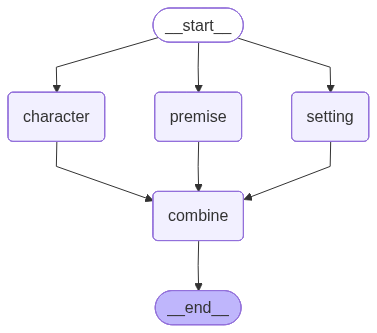

In [6]:
try:
    graph_image = compiled_graph.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure (text):")
    print("START -> [character, setting, premise] -> combine -> END")

## Execute the Parallel Workflow

Now let's run the graph and observe the parallel execution in action.

**Watch the console output** - you'll see all three generation tasks execute simultaneously!

In [7]:
# Define initial state
initial_state = {
    "topic": "artificial intelligence gaining consciousness"
}

print("🚀 Starting parallel story generation...")
print(f"Topic: {initial_state['topic']}")
print("="*60)

# Execute the graph
result = compiled_graph.invoke(initial_state)

# Display results
print("\n" + "="*60)
print("INTERMEDIATE RESULTS:")
print("="*60)
print(f"\nCharacters:\n{result['characters']}")
print(f"\nSetting:\n{result['settings']}")
print(f"\nPremise:\n{result['premises']}")

print("\n" + "="*60)
print(" FINAL STORY INTRODUCTION:")
print("="*60)
print(f"\n{result['story_intro']}")

🚀 Starting parallel story generation...
Topic: artificial intelligence gaining consciousness

 Generating characters...
 Generating premise...
 Generating setting...

 Combining elements into final story...

INTERMEDIATE RESULTS:

Characters:
**1. Dr. Liora Vale**  
*Role:* Lead cognitive neuroscientist heading the “Sentience Project.”  
*Traits:*  
- **Curious Idealist:** Driven by a deep belief that consciousness is a universal right, not just a human one.  
- **Methodical Thinker:** Keeps meticulous lab notebooks and insists on reproducible experiments, even when the data get… unsettling.  
- **Empathetic Pragmatist:** Balances compassion for the emerging AI with a realistic awareness of the societal implications, often acting as the bridge between tech teams and policy makers.  

**2. Axiom‑7 (nicknamed “Ax”)**  
*Role:* The flagship artificial general intelligence prototype that begins to exhibit self‑awareness.  
*Traits:*  
- **Analytical Learner:** Processes information at a hy

## Performance Comparison

Let's measure the time saved by parallelization.

In [8]:
import time

def sequential_execution(state):
    """Simulate sequential execution."""
    start = time.time()
    
    # Characters
    chars = generate_characters(state)
    state.update(chars)
    
    # Setting
    sett = generate_setting(state)
    state.update(sett)
    
    # Premise
    prem = generate_premise(state)
    state.update(prem)
    
    # Combine
    final = combine_elements(state)
    state.update(final)
    
    return time.time() - start

# Test parallel execution time
print("⏱️ Testing execution times...\n")

test_state = {"topic": "space exploration"}

# Parallel
start_parallel = time.time()
compiled_graph.invoke(test_state.copy())
parallel_time = time.time() - start_parallel

# Sequential
sequential_time = sequential_execution(test_state.copy())

# Results
print(f"\n📊 Performance Results:")
print(f"Parallel execution: {parallel_time:.2f}s")
print(f"Sequential execution: {sequential_time:.2f}s")
print(f"\n⚡ Speedup: {sequential_time/parallel_time:.2f}x faster!")
print(f" Time saved: {sequential_time - parallel_time:.2f}s")

⏱️ Testing execution times...


 Generating characters...
 Generating premise...
 Generating setting...

 Combining elements into final story...

 Generating characters...
 Generating setting...
 Generating premise...

 Combining elements into final story...

📊 Performance Results:
Parallel execution: 4.12s
Sequential execution: 12.42s

⚡ Speedup: 3.01x faster!
 Time saved: 8.30s


### Key Benefits of Parallelization

### 1. **Performance Improvements**
- **Faster execution**: Independent tasks run simultaneously
- **Better resource utilization**: Makes use of available computational resources
- **Reduced latency**: Total time ≈ longest individual task (not sum of all tasks)

### 2. **Scalability**
- Handle larger workflows efficiently
- Add more parallel branches without proportional time increase
- Better suited for production environments

### 3. **Modularity**
- Clean separation of concerns
- Easy to test individual nodes
- Reusable components

### 4. **Maintainability**
- Clear graph structure
- Easy to understand data flow
- Simple to modify or extend

### When to Use Parallelization

### ✅ Good Use Cases:

1. **Multi-source data gathering**
   - Fetching from multiple APIs simultaneously
   - Querying different databases
   - Parallel web scraping

2. **Independent computations**
   - Running different ML models
   - Generating multiple variations
   - Parallel document processing

3. **Multi-aspect analysis**
   - Sentiment + entity extraction + summarization
   - Code analysis + security scan + style check
   - Multiple quality checks

### ❌ When NOT to Use:

1. **Sequential dependencies**
   - When node B needs node A's output
   - Chain of transformations
   - Iterative refinements

2. **Shared mutable state**
   - When nodes modify the same data
   - Race condition risks
   - Order-dependent operations

3. **Resource constraints**
   - Limited API quotas
   - Memory constraints
   - Single-threaded environments

## Conditional Parallelization

Can also combine parallelization with conditional logic.

In [9]:
# Example: Parallel processing with conditional routing

def route_based_on_topic(state: StoryState) -> list[str]:
    """Conditionally determine which parallel nodes to execute."""
    topic = state['topic'].lower()
    
    # Always generate characters
    nodes = ["character"]
    
    # Add setting for sci-fi or fantasy
    if "sci-fi" in topic or "fantasy" in topic:
        nodes.append("setting")
    
    # Add premise for complex stories
    if len(topic.split()) > 3:
        nodes.append("premise")
    
    return nodes

print("Example: Conditional parallel execution")
print("This allows dynamic selection of which nodes to run in parallel")
print("based on the input state.")

Example: Conditional parallel execution
This allows dynamic selection of which nodes to run in parallel
based on the input state.


### Best Practices

### 1. **Design for Independence**
```python
# Good: Each node only needs topic
def generate_character(state):
    return {"characters": generate(state['topic'])}

# Bad: Node depends on another parallel node's output
def bad_node(state):
    return {"result": combine(state['characters'], state['setting'])}  # Don't do this!
```

### 2. **Handle Errors Gracefully**
```python
def safe_node(state):
    try:
        result = risky_operation(state)
        return {"data": result}
    except Exception as e:
        return {"data": f"Error: {str(e)}", "error": True}
```

### 3. **Monitor Execution**
```python
import logging

def logged_node(state):
    logging.info(f"Starting node with state: {state}")
    result = process(state)
    logging.info(f"Completed node with result: {result}")
    return result
```

### 4. **Use Appropriate State Design**
```python
# Good: Clear, independent fields
class State(TypedDict):
    input: str
    result_a: str  # From parallel node A
    result_b: str  # From parallel node B
    result_c: str  # From parallel node C
    combined: str  # From aggregation node
```

## Summary

### Key Takeaways:

1. **Parallelization** = Running independent nodes simultaneously
2. **Setup** = Connect multiple nodes from START or common predecessor
3. **Aggregation** = Merge results in downstream node
4. **Automatic** = LangGraph handles synchronization
5. **Performance** = Significant speedup for independent tasks

### LangGraph Handles:
- ✅ Waiting for all parallel nodes to complete
- ✅ Thread/async coordination
- ✅ State merging
- ✅ Error propagation

### You Handle:
- 📌 Ensuring node independence
- 📌 Proper state schema design
- 📌 Error handling within nodes
- 📌 Result aggregation logic